<a href="https://colab.research.google.com/github/janhavi-giri/semi-ontap-mimic/blob/main/semiconductor_image_classification_crispdm_ontap_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Semiconductor Defect Image Classification (CRISP‑DM) — Colab Demo of ONTAP Core Features**  

### **End‑to‑end data flow + ONTAP “equivalent primitives” (Snapshots, FlexClone, FlexGroup^*)**

**Dataset (open source):** *Carinthia SEM defect dataset* (6 classes), Zenodo, CC BY 4.0.  
DOI: **10.5281/zenodo.10715190**  
Record: https://zenodo.org/records/10715190

**NetApp ONTAP concepts referenced (production equivalents):**
- **Snapshot copies (dataset/model lineage + rollback):** https://docs.netapp.com/us-en/ontap/concepts/snapshot-copies-concept.html  
- **FlexClone (space‑efficient dataset branching):** https://docs.netapp.com/us-en/ontap/volumes/flexclone-efficient-copies-concept.html  
- **FlexGroup (scale‑out NAS for throughput + metadata heavy workloads):** https://docs.netapp.com/us-en/ontap/flexgroup/definition-concept.html  

**What this notebook demonstrates**
- A standard [**CRISP‑DM**](https://www.udacity.com/blog/2025/03/crisp-dm-explained-a-proven-data-mining-methodology.html) workflow for semiconductor image classification
- Where data friction appears (ingest, cleaning, iteration, throughput)
- How ONTAP primitives map to the same bottlenecks in production

## **Colab cannot run ONTAP directly for every customer; this demo shows the mechanisms and maps them to ONTAP features used in real deployments.**

## 1) Business Understanding (CRISP‑DM)

**Problem:** classify SEM defect images into defect classes to speed triage, reduce manual review, and improve consistency.

**Success metrics (demo):**
- **Accuracy**
- **Macro‑F1** (robust to class imbalance)

**ONTAP mapping (why infra matters):**
- **Snapshots:** freeze “golden” dataset/model states for auditability and reproducible regressions.
- **FlexClone:** branch experiments (new augmentations/models) without full dataset copies.
- **FlexGroup:** scale‑out file performance for many small image files to keep GPUs/CPUs fed.

In [1]:
#@title 2) Environment setup
import os, shutil, subprocess, time, re
from pathlib import Path

def run(cmd, check=True):
    print(">>", " ".join(cmd))
    p = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    print(p.stdout)
    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed: {' '.join(cmd)}")
    return p.stdout

run(["bash","-lc","python -V"])
run(["bash","-lc","nvidia-smi || true"])

# Install minimal dependencies (Colab often has torch already)
run(["bash","-lc","pip -q install -U pandas scikit-learn matplotlib tqdm torch torchvision && pip install -q Pillow==10.3.0 || true"])

import pandas as pd
import numpy as np
import torch, torchvision
from PIL import Image
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


>> bash -lc python -V
Python 3.12.12

>> bash -lc nvidia-smi || true
Sat Feb 28 05:18:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |   

# **ONTAP Primitive (Mimic)**
## These functions provide a programmatic way to interact with directory structures in a manner that simulates the behavior and benefits of NetApp ONTAP's advanced data management features for datasets and model artifacts.

**snapshot_create(src_dir, snaps_dir, name):** This function mimics an **ONTAP Snapshot**. Its purpose is to create a point-in-time reference copy of a source directory. In this demo, it achieves this by performing a full shutil.copytree operation. It also ensures that a snapshot with the given name doesn't already exist to prevent accidental overwrites.

**snapshot_restore(snap_path, dst_dir): This function mimics **ONTAP Snapshot rollback**. It restores a destination directory to a state previously captured by a snapshot. It does this by first deleting the current content of the destination directory and then copying all files from the specified snapshot back into it.

**flexclone_create(src_dir, clone_dir, mode='auto'):** This function mimics **ONTAP FlexClone**, which is designed to create space-efficient copies of directories. It attempts to create the clone using a prioritized approach for space efficiency:

It first tries a reflink copy (cp -a --reflink=auto), which creates copy-on-write clones. This is the most efficient method and closest to how FlexClone works in ONTAP ***(Actual ONTAP is redirect -on-write, this is for conceptual demo only)***

If reflink isn't supported or fails, it tries a hardlink clone (cp -al). Hard links are also space-efficient but mean that the original and clone share the same file data, so changes to one will affect the other.
As a last resort, if neither reflink nor hardlink is possible, it falls back to a full copy (shutil.copytree), which is less space-efficient but ensures an independent copy.




In [2]:
# =========================
# ONTAP primitives (mimic)
# =========================
import os, time, shutil, subprocess
from pathlib import Path

def _run(cmd):
   p = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
   return p.returncode, p.stdout

def snapshot_create(src_dir: Path, snaps_dir: Path, name: str):
   """
   Mimic ONTAP Snapshot: create a point-in-time reference of a directory.
   Implementation: rsync copy (simple, portable). For small demo datasets this is fine.
   """
   src_dir = Path(src_dir)
   snaps_dir = Path(snaps_dir)
   snaps_dir.mkdir(parents=True, exist_ok=True)
   snap_path = snaps_dir / name
   if snap_path.exists():
       raise FileExistsError(f"Snapshot exists: {snap_path}")
   t0 = time.time()
   shutil.copytree(src_dir, snap_path)
   dt = time.time() - t0
   print(f"[snapshot_create] {name} -> {snap_path} ({dt:.2f}s)")
   return snap_path, dt

def snapshot_restore(snap_path: Path, dst_dir: Path):
   """
   Mimic Snapshot rollback: restore directory to snapshot state.
   """
   snap_path = Path(snap_path)
   dst_dir = Path(dst_dir)
   if dst_dir.exists():
       shutil.rmtree(dst_dir)
   t0 = time.time()
   shutil.copytree(snap_path, dst_dir)
   dt = time.time() - t0
   print(f"[snapshot_restore] {snap_path.name} -> {dst_dir} ({dt:.2f}s)")
   return dt

def flexclone_create(src_dir: Path, clone_dir: Path, mode="auto"):
   """
   Mimic FlexClone: create a space-efficient clone.
   Tries in order:
     1) reflink copy (copy-on-wSrite) if supported by filesystem
     2) hardlink clone (space-efficient but couples files; OK for 'read-mostly' datasets)
     3) fallback to full copy
   """
   src_dir = Path(src_dir)
   clone_dir = Path(clone_dir)
   if clone_dir.exists():
       raise FileExistsError(f"Clone exists: {clone_dir}")

   # 1) Try reflink (best mimic of CoW)
   if mode in ("auto", "reflink"):
       rc, out = _run(["bash","-lc", f"cp -a --reflink=auto '{src_dir}' '{clone_dir}'"])
       if rc == 0:
           print("[flexclone_create] reflink clone created:", clone_dir)
           return "reflink"

   # 2) Try hardlink clone (works well for immutable datasets)
   if mode in ("auto", "hardlink"):
       clone_dir.mkdir(parents=True, exist_ok=True)
       rc, out = _run(["bash","-lc", f"cp -al '{src_dir}/.' '{clone_dir}/'"])
       if rc == 0:
           print("[flexclone_create] hardlink clone created:", clone_dir)
           return "hardlink"

       # cleanup if failed
       if clone_dir.exists():
           shutil.rmtree(clone_dir)

   # 3) Fallback: full copy
   shutil.copytree(src_dir, clone_dir)
   print("[flexclone_create] fallback full copy clone created:", clone_dir)
   return "copy"

def du(path: Path):
   rc, out = _run(["bash","-lc", f"du -sh '{path}'"])
   return out.strip()

## **Mimic ONTAP volumes**

In [4]:
ROOT = Path("/content/semicon_cls")
# Mimic ONTAP volumes
VOL_ROOT = ROOT/"ontap_mimic"
VOL_DS   = VOL_ROOT/"vol_semicon_ds"      # dataset "volume"
VOL_MDL  = VOL_ROOT/"vol_semicon_models"  # model artifacts "volume"
SNAPS    = VOL_ROOT/"snapshots"

for p in [VOL_DS, VOL_MDL, SNAPS]:
   p.mkdir(parents=True, exist_ok=True)

print("VOL_DS:", VOL_DS)
print("VOL_MDL:", VOL_MDL)
print("SNAPS:", SNAPS)

VOL_DS: /content/semicon_cls/ontap_mimic/vol_semicon_ds
VOL_MDL: /content/semicon_cls/ontap_mimic/vol_semicon_models
SNAPS: /content/semicon_cls/ontap_mimic/snapshots


## 2) Data Understanding (CRISP‑DM)

We download the dataset from Zenodo, inspect the metadata CSV, confirm the image folder, and view sample images.

In [5]:

#@title Download Carinthia dataset (Zenodo)
ROOT = Path("/content/semicon_cls")
RAW  = ROOT/"raw"
RAW.mkdir(parents=True, exist_ok=True)

# Zenodo direct download URL for record 10715190 (data.zip)
DATA_URL = "https://zenodo.org/records/10715190/files/data.zip?download=1"
ZIP_PATH = RAW/"data.zip"

if not ZIP_PATH.exists():
    run(["bash","-lc", f"wget -O {ZIP_PATH} '{DATA_URL}'"])

EXTRACT_DIR = RAW/"carinthia"
if EXTRACT_DIR.exists():
    shutil.rmtree(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

run(["bash","-lc", f"unzip -q {ZIP_PATH} -d {EXTRACT_DIR}"])
run(["bash","-lc", f"find {EXTRACT_DIR} -maxdepth 3 -type f | head -n 30"])


>> bash -lc wget -O /content/semicon_cls/raw/data.zip 'https://zenodo.org/records/10715190/files/data.zip?download=1'
--2026-02-28 05:19:46--  https://zenodo.org/records/10715190/files/data.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.184.103.118, 188.184.98.114, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133840870 (128M) [application/octet-stream]
Saving to: ‘/content/semicon_cls/raw/data.zip’

     0K .......... .......... .......... .......... ..........  0%  142K 15m23s
    50K .......... .......... .......... .......... ..........  0%  304K 11m16s
   100K .......... .......... .......... .......... ..........  0%  166M 7m31s
   150K .......... .......... .......... .......... ..........  0%  355K 7m10s
   200K .......... .......... .......... .......... ..........  0% 2.08M 5m56s
   250K .......... .......... .......... .......... ..........  0%  331M 4m57s
   300K ..

'/content/semicon_cls/raw/carinthia/data/images/c4676b23b4e144e2bf51683437826d15.jpg\n/content/semicon_cls/raw/carinthia/data/images/c2754fb6740d4a78bd184626bdfa8d22.jpg\n/content/semicon_cls/raw/carinthia/data/images/2d5c0282f04a4982b28d4fcae291b6b7.jpg\n/content/semicon_cls/raw/carinthia/data/images/975c4405258347acbae98637fd5f7cec.jpg\n/content/semicon_cls/raw/carinthia/data/images/17d8458adbd0417d8f06b90f83e028f8.jpg\n/content/semicon_cls/raw/carinthia/data/images/0433ed536ca14499aa7ba2fa3c63425f.jpg\n/content/semicon_cls/raw/carinthia/data/images/1c951dfe68904ea6813be21af6456072.jpg\n/content/semicon_cls/raw/carinthia/data/images/b189ed0941394a139ad9a14a292b4fa4.jpg\n/content/semicon_cls/raw/carinthia/data/images/01160b7293e54a2aa4afb7684758023f.jpg\n/content/semicon_cls/raw/carinthia/data/images/b5e532968f7e4c9abd839aaf6197608c.jpg\n/content/semicon_cls/raw/carinthia/data/images/82aa80881bc647579a483e50c512f1c2.jpg\n/content/semicon_cls/raw/carinthia/data/images/3c227744afff49629

 ## **"Snapshot" the ingested dataset**

In [6]:
# After you have EXTRACT_DIR ready:
EXTRACT_DIR = Path("/content/semicon_cls/raw/carinthia")
INGEST_SRC = EXTRACT_DIR  # your extracted dataset folder
INGEST_DST = VOL_DS/"dataset_ingested"
if INGEST_DST.exists():
   shutil.rmtree(INGEST_DST)
shutil.copytree(INGEST_SRC, INGEST_DST)

# "Snapshot" the ingested dataset
snap_ingest, _ = snapshot_create(INGEST_DST, SNAPS, "ds_raw_ingested_v1")
print(du(INGEST_DST), du(snap_ingest))

[snapshot_create] ds_raw_ingested_v1 -> /content/semicon_cls/ontap_mimic/snapshots/ds_raw_ingested_v1 (0.49s)
149M	/content/semicon_cls/ontap_mimic/vol_semicon_ds/dataset_ingested 149M	/content/semicon_cls/ontap_mimic/snapshots/ds_raw_ingested_v1


In [7]:

#@title Locate metadata CSV + images
csv_candidates = list(EXTRACT_DIR.rglob("*.csv"))
img_candidates = list(EXTRACT_DIR.rglob("*.jpg"))

print("CSV files:", [str(p.relative_to(EXTRACT_DIR)) for p in csv_candidates[:10]])
print("Num .jpg images:", len(img_candidates))

assert len(csv_candidates) >= 1, "No CSV found; check extraction output above."
CSV_PATH = csv_candidates[0]

# Common folder pattern: .../data/images (but detect robustly)
IMG_DIR = (EXTRACT_DIR/"data"/"images") if (EXTRACT_DIR/"data"/"images").exists() else img_candidates[0].parent
print("Using IMG_DIR:", IMG_DIR)

df = pd.read_csv(CSV_PATH, sep=';')
print("CSV shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


CSV files: ['data/carinthia.csv']
Num .jpg images: 4591
Using IMG_DIR: /content/semicon_cls/raw/carinthia/data/images
CSV shape: (4591, 3)
Columns: ['image_path', 'file_name', 'label']


,image_path,file_name,label
0,data/images/2661734b21874fdf9e35a4319a9e7462.jpg,2661734b21874fdf9e35a4319a9e7462.jpg,6
1,data/images/0c8af9b8e62f4cb498392e806236e5e0.jpg,0c8af9b8e62f4cb498392e806236e5e0.jpg,6
2,data/images/ecb33a23f90b47fe8ee1dfe3e4d5f0df.jpg,ecb33a23f90b47fe8ee1dfe3e4d5f0df.jpg,6
3,data/images/adc88a3f9fb34ae79142ba9f12a6f1e1.jpg,adc88a3f9fb34ae79142ba9f12a6f1e1.jpg,6
4,data/images/bc228459f662459f80fbce99bedd9d20.jpg,bc228459f662459f80fbce99bedd9d20.jpg,6


Detected image column: file_name
Detected label column: label
Usable rows with resolvable images: 4591 / 4591


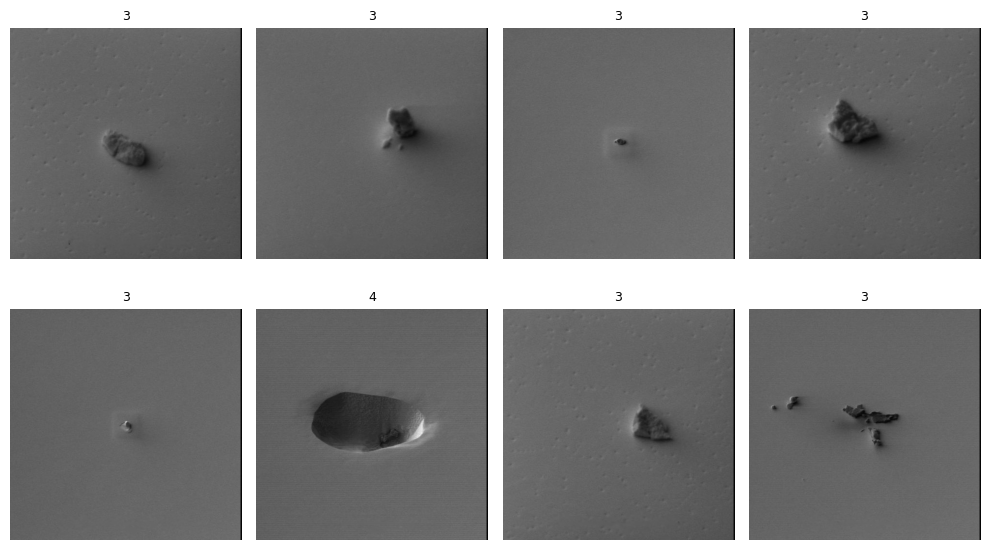

In [8]:

#@title Visual sanity-check: show a few images (auto-detect columns)
import matplotlib.pyplot as plt

def pick_column(cols, patterns):
    cols_l = [c.lower() for c in cols]
    for pat in patterns:
        for i,c in enumerate(cols_l):
            if re.search(pat, c):
                return cols[i]
    return None

cols = list(df.columns)
img_col = pick_column(cols, [r"file", r"image", r"img", r"path", r"name"])
label_col = pick_column(cols, [r"label", r"class", r"category", r"defect", r"y"])

# fallback heuristics
if img_col is None:
    for c in cols:
        if df[c].astype(str).str.contains(r"\.jpg|\.png|\.jpeg", case=False, regex=True).mean() > 0.5:
            img_col = c; break

if label_col is None:
    cand = [(c, df[c].nunique()) for c in cols if c != img_col]
    cand = sorted(cand, key=lambda x: x[1])
    label_col = cand[0][0] if cand else None

print("Detected image column:", img_col)
print("Detected label column:", label_col)
assert img_col and label_col, "Could not detect columns. Inspect df.head() and set img_col/label_col manually."

def resolve_path(v):
    v = str(v)
    p = Path(v)
    if p.is_file():
        return p
    return IMG_DIR/Path(v).name

tmp = df[[img_col, label_col]].copy()
tmp["img_path"] = tmp[img_col].apply(resolve_path)
tmp = tmp[tmp["img_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

print("Usable rows with resolvable images:", len(tmp), "/", len(df))

sample = tmp.sample(min(8, len(tmp)), random_state=0)
plt.figure(figsize=(10,6))
for i, (_, r) in enumerate(sample.iterrows()):
    img = Image.open(r["img_path"]).convert("RGB")
    ax = plt.subplot(2,4,i+1)
    ax.imshow(img)
    ax.set_title(str(r[label_col])[:20], fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [9]:
# Create two experiment branches from the ingested dataset
EXP_A = VOL_DS/"dataset_expA"
EXP_B = VOL_DS/"dataset_expB"

clone_mode_A = flexclone_create(INGEST_DST, EXP_A)  # reflink/hardlink/copy
clone_mode_B = flexclone_create(INGEST_DST, EXP_B)

print("EXP_A clone mode:", clone_mode_A, du(EXP_A))
print("EXP_B clone mode:", clone_mode_B, du(EXP_B))

[flexclone_create] reflink clone created: /content/semicon_cls/ontap_mimic/vol_semicon_ds/dataset_expA
[flexclone_create] reflink clone created: /content/semicon_cls/ontap_mimic/vol_semicon_ds/dataset_expB
EXP_A clone mode: reflink 149M	/content/semicon_cls/ontap_mimic/vol_semicon_ds/dataset_expA
EXP_B clone mode: reflink 149M	/content/semicon_cls/ontap_mimic/vol_semicon_ds/dataset_expB


## 3) Data Preparation (CRISP‑DM)

We:
1. Resolve image paths from the CSV  
2. Encode labels  
3. Create stratified train/val/test splits  
4. Define transforms (augmentations for train; deterministic preprocessing for eval)

**ONTAP equivalent hooks**
- After cleaning/splitting: **Snapshot** the dataset state (reproducible lineage).
- For alternative splits/augmentations: **FlexClone** to create space‑efficient branches.

In [10]:

#@title Build train/val/test splits + PyTorch datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

df2 = df[[img_col, label_col]].copy()
df2["img_path"] = df2[img_col].apply(resolve_path)
df2 = df2[df2["img_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

classes = sorted(df2[label_col].astype(str).unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
df2["y"] = df2[label_col].astype(str).map(class_to_idx)

train_df, test_df = train_test_split(df2, test_size=0.15, random_state=42, stratify=df2["y"])
train_df, val_df  = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df["y"])

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Classes:", classes)

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class SemiDefectDataset(Dataset):
    def __init__(self, df_, tf_):
        self.df = df_.reset_index(drop=True)
        self.tf = tf_
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        p = self.df.loc[i, "img_path"]
        y = int(self.df.loc[i, "y"])
        img = Image.open(p).convert("RGB")
        x = self.tf(img)
        return x, y

train_ds = SemiDefectDataset(train_df, train_tf)
val_ds   = SemiDefectDataset(val_df, eval_tf)
test_ds  = SemiDefectDataset(test_df, eval_tf)


Split sizes: 3316 586 689
Classes: ['1', '2', '3', '4', '5', '6']


## 4) Modeling (CRISP‑DM)

We train a baseline supervised CNN classifier using transfer learning:
- **ResNet‑18** pretrained on ImageNet
- Replace the final layer to match the dataset’s number of classes

**ONTAP equivalents**
- **FlexGroup** helps keep accelerators fed as file counts grow.
- **FlexClone** supports parallel experiments (different augmentations/models) without full copies.

In [11]:

#@title Train a baseline classifier (ResNet‑18)
import torch, torch.nn as nn
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import time

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss()

def eval_dl(dl):
    model.eval()
    ys, ps = [], []
    tot_loss, n = 0.0, 0
    with torch.no_grad():
        for x,y in dl:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            tot_loss += loss.item() * x.size(0)
            n += x.size(0)
            ps.append(torch.argmax(logits, dim=1).cpu().numpy())
            ys.append(y.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    acc = (y_true == y_pred).mean()
    f1m = f1_score(y_true, y_pred, average="macro")
    return {"loss": tot_loss/n, "acc": acc, "macro_f1": f1m, "y_true": y_true, "y_pred": y_pred}

epochs = 3  # short for live demo; increase for better accuracy
for ep in range(1, epochs+1):
    model.train()
    t0 = time.time()
    running, n = 0.0, 0
    for x,y in train_dl:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        running += loss.item() * x.size(0)
        n += x.size(0)
    dt = time.time() - t0
    valm = eval_dl(val_dl)
    print(f"epoch {ep}/{epochs}  train_loss={running/n:.4f}  val_loss={valm['loss']:.4f}  val_acc={valm['acc']:.3f}  val_macroF1={valm['macro_f1']:.3f}  time={dt:.1f}s")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 243MB/s]


epoch 1/3  train_loss=0.1701  val_loss=0.0553  val_acc=0.993  val_macroF1=0.978  time=6.0s
epoch 2/3  train_loss=0.0270  val_loss=0.0725  val_acc=0.983  val_macroF1=0.917  time=4.5s
epoch 3/3  train_loss=0.0174  val_loss=0.0734  val_acc=0.973  val_macroF1=0.851  time=4.8s


## 5) Evaluation (CRISP‑DM)

We evaluate on the held‑out test set and show macro‑F1 plus a confusion matrix.

**ONTAP equivalent:** snapshot the dataset + model artifacts together to make results reproducible and auditable.

Test metrics: {'loss': 0.07461204121351588, 'acc': np.float64(0.9753265602322206), 'macro_f1': 0.6931443338334232}

Classification report:
              precision    recall  f1-score   support

           1      1.000     0.500     0.667         8
           2      0.500     1.000     0.667         1
           3      0.976     1.000     0.988       602
           4      1.000     0.721     0.838        43
           5      0.000     0.000     0.000         1
           6      1.000     1.000     1.000        34

    accuracy                          0.975       689
   macro avg      0.746     0.703     0.693       689
weighted avg      0.977     0.975     0.973       689



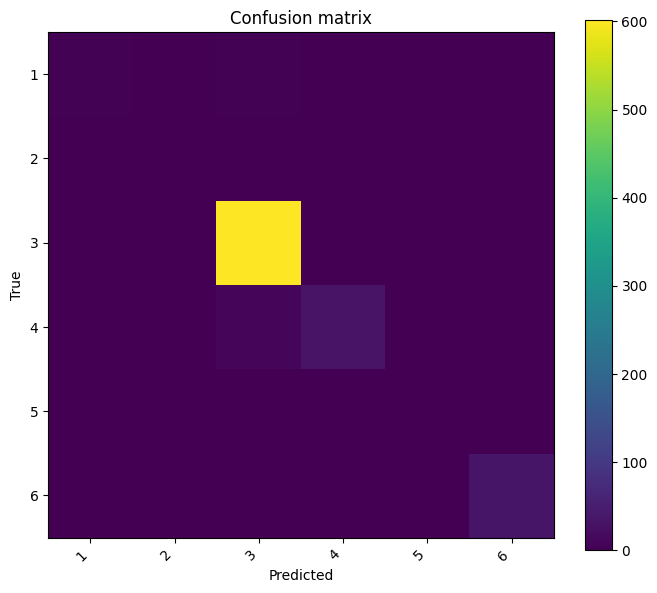

In [12]:

#@title Evaluate on held‑out test set
import matplotlib.pyplot as plt

testm = eval_dl(test_dl)
print("Test metrics:", {k:testm[k] for k in ["loss","acc","macro_f1"]})

print("\nClassification report:")
print(classification_report(testm["y_true"], testm["y_pred"], target_names=classes, digits=3))

cm = confusion_matrix(testm["y_true"], testm["y_pred"])
plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.tight_layout()
plt.show()


## **Snapshot both data and model “volumes” (point-in-time record)**

In [16]:
RUN_ID = "run_001A"
RUN_DIR = VOL_MDL/RUN_ID
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Save your model artifact into RUN_DIR (example)
torch.save(..., RUN_DIR/"model.pt")

# Snapshot both data and model “volumes” (point-in-time record)
snap_data, _ = snapshot_create(EXP_A, SNAPS, f"{RUN_ID}_data")
snap_model,_ = snapshot_create(RUN_DIR, SNAPS, f"{RUN_ID}_model")

print("snap_data:", snap_data)
print("snap_model:", snap_model)

[snapshot_create] run_001A_data -> /content/semicon_cls/ontap_mimic/snapshots/run_001A_data (0.49s)
[snapshot_create] run_001A_model -> /content/semicon_cls/ontap_mimic/snapshots/run_001A_model (0.00s)
snap_data: /content/semicon_cls/ontap_mimic/snapshots/run_001A_data
snap_model: /content/semicon_cls/ontap_mimic/snapshots/run_001A_model


## 6) Deployment (CRISP‑DM)

For this demo, “deployment” means:
- Save model + label map
- Provide a simple inference function (single image → predicted class)
- Record dataset/model version IDs (lineage)

**ONTAP equivalents**
- **Snapshots:** freeze model+data state for rollback.
- **FlexClone:** create a staging branch for validation without copying large datasets.

In [17]:

#@title Save artifacts + run inference on a few images
ART = ROOT/"artifacts"
ART.mkdir(parents=True, exist_ok=True)

ckpt_path = ART/"resnet18_carinthia.pt"
torch.save({"state_dict": model.state_dict(),
            "classes": classes,
            "img_size": [224,224]}, ckpt_path)

print("Saved:", ckpt_path, "size(MB)=", ckpt_path.stat().st_size/1e6)

def predict_one(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = eval_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        p = int(torch.argmax(logits, dim=1).item())
    return classes[p]

for i in [0, 5, 10]:
    p = test_df.iloc[i]["img_path"]
    print(Path(p).name, "-> pred:", predict_one(p), "| true:", str(test_df.iloc[i][label_col]))


Saved: /content/semicon_cls/artifacts/resnet18_carinthia.pt size(MB)= 44.799115
5a7d5bc282204eceb0b74d8f2d701927.jpg -> pred: 3 | true: 3
fc34ee060ec0430f83c5e8f7e19183d1.jpg -> pred: 3 | true: 3
c7703581a3634beb996236ce5e8f95a5.jpg -> pred: 3 | true: 3


## **Rollback EXP_A to a known snapshot**

In [18]:
# Simulate a bad change
bad_file = next(EXP_A.rglob("*.csv"), None)
if bad_file:
   with open(bad_file, "a") as f:
       f.write("\n# bad edit")
   print("Injected change into:", bad_file)

# Rollback EXP_A to a known snapshot
snapshot_restore(SNAPS/f"{RUN_ID}_data", EXP_A)
print("Rolled back EXP_A to:", f"{RUN_ID}_data")

Injected change into: /content/semicon_cls/ontap_mimic/vol_semicon_ds/dataset_expA/data/carinthia.csv
[snapshot_restore] run_001A_data -> /content/semicon_cls/ontap_mimic/vol_semicon_ds/dataset_expA (0.49s)
Rolled back EXP_A to: run_001A_data


## **7)** **ONTAP Feature Mapping**

| CRISP‑DM stage | What happens here | Pain point at scale | ONTAP capability |
|---|---|---|---|
| Data understanding | Download + inspect | “Which exact dataset version?” | **Snapshots** (point‑in‑time dataset state) |
| Data prep | Split/clean/augment | Copies for each experiment | **FlexClone** (space‑efficient branches) |
| Modeling | Train CNN | Idle accelerators if storage can’t feed small files | **FlexGroup** (scale‑out NAS throughput + load distribution) |
| Evaluation | Compare runs | Hard to reproduce/regress | **Snapshots** freeze model+data state |
| Deployment | Promote model | Need safe staging/rollback | **FlexClone** for staging; **Snapshots** for rollback |



## **Conclusion**  
“Here’s a standard CRISP‑DM workflow on a real SEM defect dataset. At enterprise scale, the friction is not the CNN — it’s dataset lineage, fast experiment branching, and feeding accelerators with lots of small files. ONTAP Snapshots, FlexClone, and FlexGroup map directly to those bottlenecks: reproducible lineage, instant branching, and scale‑out throughput.”